In [125]:
import argparse
import traceback
import time
import shutil
import logging
import yaml
import sys
import numpy as np
import copy
import os, glob, pickle

from PIL import Image

import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# folderOne = "AutomotiveProperAlignment1"
# folderOne = "Every10SimultaneousMethod"
folderOne = "DensificationCloseTest"
# folderOne = "AutomotiveAllForOne3"
# folderTwo = "AutomotiveFixedAttempt2"
# folderTwo = "AutomotiveAllForOneControlled4"
# folderTwo = "FortyNineTests"
folderTwo = ""

In [126]:


loadLocation = folderOne
allFiles = glob.glob(os.path.join(loadLocation, '*Masked_completion*.npy'))
exampleFile = allFiles[0]
exampleFile = exampleFile.split('/')[-1]
allFileNums = []
allSettingNums = []
for tempFile in allFiles:
    tempFile = tempFile.split('/')[-1]
    plzSplit = tempFile.split('_')[0]
    plzSplit2 = tempFile.split('_')[1]
    allFileNums.append(int(plzSplit2))
    allSettingNums.append(int(plzSplit))
largestFileNum = np.max(allFileNums)
smallestFileNum = np.min(allFileNums)
largestSettingNum = np.max(allSettingNums)
smallestSettingNum = np.min(allSettingNums)
print("argest is")
print(largestFileNum)
print(smallestFileNum)

batchNum = 7
actualBatchNum = 7
totalDistanceError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityError = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalDistanceInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalIntensityErrorInput = np.zeros((largestSettingNum - smallestSettingNum + 1,actualBatchNum))
totalPixels = np.zeros(actualBatchNum)
totalOriginDistances = np.zeros(actualBatchNum)
channelNum = 2 * batchNum
for file_num in range(largestFileNum - smallestFileNum+1):
    file_num = file_num + smallestFileNum
    # if(file_num != 4):
    #     continue
    if(os.path.isfile(loadLocation +'/' + str(largestSettingNum) + '_' + str(file_num) + '_Masked_completion_897.pth.npy') == False):
        print(loadLocation +'/' + str(largestSettingNum) + '_' + str(file_num) + '_Masked_completion_897.pth.npy')
        print("does note xist")
        continue
    GTPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_GT_completion_897.pth.npy'
    InputPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_Input_completion_897.pth.npy'
    GT = np.reshape(np.load(GTPath)[:,0],(channelNum,64,1024))
    Input = np.reshape(np.load(InputPath)[:,0],(channelNum,64,1024))
    print(np.sum(GT))
    print(np.sum(Input))
    GTdistance = GT[:batchNum]
    loggedIgnore = 0.1
    loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
    mask = np.logical_and(Input[:batchNum] <= 0.001, GTdistance > loggedIgnore)
    inputMask = np.logical_and(Input[:batchNum] > 0.001, GTdistance > loggedIgnore)
    for multiplier in range(batchNum // actualBatchNum):
        for j in range(actualBatchNum):
            k = actualBatchNum*multiplier + j
            totalPixels[j] += np.sum(mask[k])
    GTdistance = np.power(2,GTdistance*6)-1
    GTintensity = GT[batchNum:]
    # print(GT.shape)
    # print(Input.shape)
    # GTdistance = np.where(mask,GTdistance,0)
    # GTintensity =np.where(mask,GTintensity,0)

    #Get the distance between origins
    toWorld = np.squeeze(np.load(loadLocation + "/toWorld_"+ str(file_num) + ".npy"))
    fromWorld = np.squeeze(np.load(loadLocation + "/fromWorld_"+ str(file_num) + ".npy"))
    baseLine = np.array([0,0,0,1])
    origins = np.matmul(toWorld, baseLine)
    initialOrigin = np.matmul(np.linalg.inv(fromWorld), baseLine)
    origins = origins - initialOrigin
    origins = np.absolute(origins[:,:3])
    distances = np.sqrt(origins[:,0]*origins[:,0] + origins[:,1]*origins[:,1] + origins[:,2]*origins[:,2])
    # print("yessssssss")
    # print(distances)
    distances = np.reshape(distances, (batchNum//actualBatchNum, actualBatchNum))
    totalOriginDistances += np.sum(distances, 0)

    for setting_num in range(largestSettingNum - smallestSettingNum+1):
        loadNum = setting_num + smallestSettingNum
        maskedPath = loadLocation +'/' + str(loadNum) + '_' + str(file_num) + '_Masked_completion_897.pth.npy'
        print(maskedPath)
        # sharedPath = loadLocation +'/' + str(setting_num) + '_' + str(file_num) + '_Masked_Shared_completion_897.pth.npy'
        prediction = np.reshape(np.load(maskedPath)[:,0],(channelNum,64,1024))
        print(np.mean(prediction[:batchNum][mask]))
        np.clip(prediction,0,1)
        # print(np.mean(prediction))
        #no project back up
        distance = prediction[:batchNum]
        # print(np.mean(distance))
        distance = np.power(2,distance*6)-1
        # print(np.mean(distance))
        intensity = prediction[batchNum:]
        # print("mean is")
        # print(np.mean(distance[mask]))
        
        # distance = np.where(mask,distance,0)
        # intensity =np.where(mask,intensity,0)
        print(np.mean(distance))
        for multiplier in range(batchNum // actualBatchNum):
            for subSample in range(actualBatchNum):
                sample = actualBatchNum * multiplier + subSample
                distanceError = np.sum(np.absolute(distance[sample][mask[sample]] - GTdistance[sample][mask[sample]]) )#/ GTdistance[sample][mask[sample]])
                intensityError = np.sum(np.absolute(intensity[sample][mask[sample]] - GTintensity[sample][mask[sample]]) )#/ GTintensity[sample][mask[sample]])
                distanceErrorInput = np.sum(np.absolute(distance[sample][inputMask[sample]] - GTdistance[sample][inputMask[sample]]) )#/ GTdistance[sample][mask[sample]])
                intensityErrorInput = np.sum(np.absolute(intensity[sample][inputMask[sample]] - GTintensity[sample][inputMask[sample]]) )#/ GTintensity[sample][mask[sample]])
                # print("before")
                # print(totalDistanceErrorInput)
                totalDistanceError[setting_num,subSample] += distanceError
                totalIntensityError[setting_num,subSample] += intensityError
                totalDistanceErrorInput[setting_num,subSample] += distanceErrorInput
                totalIntensityErrorInput[setting_num,subSample] += intensityErrorInput
                totalDistanceInput[setting_num,subSample] += np.sum(distance[sample][inputMask[sample]])
                print(distanceErrorInput)
                # print("after")
                # print(totalDistanceErrorInput )

        # plt.imshow(mask[5])
        # plt.axis('off')
        # plt.show()
        # plt.imshow(np.absolute(GTdistance[5] - distance[5]))
        # plt.axis('off')
        # plt.show()
        # plt.imshow(distance[5])
        # plt.axis('off')
        # plt.show()

totalOriginDistances = totalOriginDistances / (largestFileNum - smallestFileNum + 1)
print(totalDistanceErrorInput)

argest is
29
2
197796.0053772893
47144.96121980823
DensificationCloseTest/0_2_Masked_completion_897.pth.npy
0.5671981
10.3137
0.01436984450360157
2601.239109313182
2668.559536060906
3920.0959555625464
4160.088974094371
3527.81893684763
2797.315117635575
DensificationCloseTest/1_2_Masked_completion_897.pth.npy
0.5295702
7.735906
0.01436984450360157
2601.239109313182
2668.559536060906
3920.0959555625464
4160.088974094371
3527.81893684763
2797.315117635575
174966.29480837774
41073.317218340504
DensificationCloseTest/0_3_Masked_completion_897.pth.npy
0.58167076
11.936945
0.012642982054199337
2671.115338175524
3180.8486483334586
6303.1939862553345
6316.765616812745
4360.040538181391
3828.2306511229426
DensificationCloseTest/1_3_Masked_completion_897.pth.npy
0.52880013
7.9369698
0.012642982054199337
2671.115338175524
3180.8486483334586
6303.1939862553345
6316.765616812745
4360.040538181391
3828.2306511229426
215270.5371456377
52751.86631479305
DensificationCloseTest/0_4_Masked_completion_897

In [5]:
if(folderTwo != ""):
    loadLocation = folderTwo
    allFiles = glob.glob(os.path.join(loadLocation, '*Masked_completion*.npy'))
    exampleFile = allFiles[0]
    exampleFile = exampleFile.split('/')[-1]
    allFileNums = []
    allSettingNums = []
    for tempFile in allFiles:
        tempFile = tempFile.split('/')[-1]
        plzSplit = tempFile.split('_')[0]
        plzSplit2 = tempFile.split('_')[1]
        allFileNums.append(int(plzSplit2))
        allSettingNums.append(int(plzSplit))
    largestFileNum2 = np.max(allFileNums)
    smallestFileNum2 = np.min(allFileNums)
    largestSettingNum2 = np.max(allSettingNums)
    smallestSettingNum2 = np.min(allSettingNums)
    print("argest is")
    print(largestFileNum2)
    print(smallestFileNum2)
    
    totalDistanceError2 = np.zeros((largestSettingNum2 - smallestSettingNum2 + 1,8))
    totalIntensityError2 = np.zeros((largestSettingNum2 - smallestSettingNum2 + 1,8))
    totalPixels2 = np.zeros(8)
    for file_num in range(largestFileNum2 - smallestFileNum2+1):
        file_num = file_num + smallestFileNum2
        # if(file_num != 4):
        #     continue
        if(os.path.isfile(loadLocation +'/' + str(largestSettingNum2) + '_' + str(file_num) + '_Masked_completion_897.pth.npy') == False):
            print(loadLocation +'/' + str(largestSettingNum2) + '_' + str(file_num) + '_Masked_completion_897.pth.npy')
            print("does note xist")
            continue
        GTPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_GT_completion_897.pth.npy'
        InputPath = loadLocation + '/' + str(0) + '_' + str(file_num) + '_Input_completion_897.pth.npy'
        GT = np.reshape(np.load(GTPath)[:,0],(16,64,1024))
        Input = np.reshape(np.load(InputPath)[:,0],(16,64,1024))
        print(np.sum(GT))
        print(np.sum(Input))
        GTdistance = GT[:8]
        loggedIgnore = 0.1
        loggedIgnore = ((np.log2(loggedIgnore+1)) / 6)
        mask = np.logical_and(Input[:8] <= 0.001, GTdistance > loggedIgnore)
        for j in range(8):
            totalPixels2[j] += np.sum(mask[j])
        GTdistance = np.power(2,GTdistance*6)-1
        print("min distance")
        print(np.min(GTdistance[GTdistance>0.1]))
        GTintensity = GT[8:]
        # print(GT.shape)
        # print(Input.shape)
        GTdistance = np.where(mask,GTdistance,0)
        GTintensity =np.where(mask,GTintensity,0)
    
    
        for setting_num in range(largestSettingNum2 - smallestSettingNum2+1):
            loadNum = setting_num + smallestSettingNum2
            maskedPath = loadLocation +'/' + str(loadNum) + '_' + str(file_num) + '_Masked_completion_897.pth.npy'
            print(maskedPath)
            # sharedPath = loadLocation +'/' + str(setting_num) + '_' + str(file_num) + '_Masked_Shared_completion_897.pth.npy'
            prediction = np.reshape(np.load(maskedPath)[:,0],(16,64,1024))
            print(np.mean(prediction[:8][mask]))
            np.clip(prediction,0,1)
            # print(np.mean(prediction))
            #no project back up
            distance = prediction[:8]
            # print(np.mean(distance))
            distance = np.power(2,distance*6)-1
            # print(np.mean(distance))
            intensity = prediction[8:]
            # print("mean is")
            # print(np.mean(distance[mask]))
            
            distance = np.where(mask,distance,0)
            intensity =np.where(mask,intensity,0)
            print(np.mean(distance))
            for sample in range(8):
                distanceError = np.sum(np.absolute(distance[sample][mask[sample]] - GTdistance[sample][mask[sample]]) )#/ GTdistance[sample][mask[sample]])
                intensityError = np.sum(np.absolute(intensity[sample][mask[sample]] - GTintensity[sample][mask[sample]]) )#/ GTintensity[sample][mask[sample]])
        
                totalDistanceError2[setting_num,sample] += distanceError
                totalIntensityError2[setting_num,sample] += intensityError
    
            # plt.imshow(mask[5])
            # plt.axis('off')
            # plt.show()
            # plt.imshow(np.absolute(GTdistance[5] - distance[5]))
            # plt.axis('off')
            # plt.show()
            # plt.imshow(distance[5])
            # plt.axis('off')
            # plt.show()

In [127]:

print(totalPixels/(largestFileNum - smallestFileNum+1))    
print(totalOriginDistances)
print("Za Input")
totalInputPixels = (largestFileNum - smallestFileNum+1)*64*1024 - totalPixels
print(totalDistanceInput / totalInputPixels)

# totalDistanceError = np.square(totalDistanceError)

for setting_num in range(largestSettingNum - smallestSettingNum+1):
    loadNum = setting_num + smallestSettingNum
    # distanceAcc = np.sum((totalDistanceError[setting_num])) / np.sum(totalPixels)
    # intensityAcc = np.sum((totalIntensityError[setting_num])) / np.sum(totalPixels)
    # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
    # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
    # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
    # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
    distanceAcc = (totalDistanceError[setting_num]) / totalPixels
    intensityAcc = (totalIntensityError[setting_num]) / totalPixels
    # distanceAcc = (totalDistanceError[setting_num][0]) / totalPixels[0]
    # intensityAcc = (totalIntensityError[setting_num][0]) / totalPixels[0]
    # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
    # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
    
    distanceAccInput = (totalDistanceErrorInput[setting_num]) / totalInputPixels
    intensityAccInput = (totalIntensityErrorInput[setting_num]) / totalInputPixels
    print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))
    print("Input: " + str(loadNum) + " Distance is: " + str(distanceAccInput) + " Intensity is : " + str(intensityAccInput))
print("comparing the pair")
# improvement = (totalDistanceError[0][1:] - totalDistanceError[1][1:]) / totalDistanceError[0][1:] 
# print(improvement)
# if(folderTwo != ""):
#     for setting_num in range(largestSettingNum2 - smallestSettingNum2+1):
#         loadNum = setting_num + smallestSettingNum2
#         # distanceAcc = np.sum((totalDistanceError2[setting_num])) / np.sum(totalPixels2)
#         # intensityAcc = np.sum((totalIntensityError2[setting_num])) / np.sum(totalPixels2)
#         # distanceAcc = np.sum((totalDistanceError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # intensityAcc = np.sum((totalIntensityError[setting_num][1:])) / np.sum(totalPixels[1:])
#         # distanceAcc = (totalDistanceError[setting_num][1:]) / totalPixels[1:]
#         # intensityAcc = (totalIntensityError[setting_num][1:]) / totalPixels[1:]
#         distanceAcc = (totalDistanceError[setting_num]) / totalPixels
#         intensityAcc = (totalIntensityError[setting_num]) / totalPixels
#         # distanceAcc = (totalDistanceError2[setting_num][5:]) / totalPixels2[5:]
#         # intensityAcc = (totalIntensityError2[setting_num][5:]) / totalPixels2[5:]
#         # distanceAcc = (totalDistanceError[setting_num][4]) / totalPixels[4]
#         # intensityAcc = (totalIntensityError[setting_num][4]) / totalPixels[4]
#         print("Setting: " + str(loadNum) + " Distance is: " + str(distanceAcc) + " Intensity is : " + str(intensityAcc))

# print("comparing the pair")
# # improvement = (totalDistanceError[0][5:] - totalDistanceError[1][5:]) / totalDistanceError[0][5:] 
# print(improvement)

[33681.92857143 19133.67857143 18047.46428571 18377.60714286
 17690.         19808.46428571 19631.85714286]
[4.94467823e-13 4.94467823e-13 4.94467823e-13 4.94467823e-13
 4.94467823e-13 4.94467823e-13 4.94467823e-13]
Za Input
[[4.15835985 1.75480143 1.77078812 1.70516984 1.72159244 1.87873339
  1.77187244]
 [4.15835985 1.75480143 1.77078812 1.70516984 1.72159244 1.87873339
  1.77187244]]
Setting: 0 Distance is: [2.44412446 3.66281202 3.81680144 3.65060187 3.78187187 3.56063208
 3.38871364] Intensity is : [0.13566786 0.14122361 0.14611552 0.1437985  0.1483882  0.14807155
 0.14393672]
Input: 0 Distance is: [3.66750864e-07 7.45931767e-02 7.17181190e-02 8.67132854e-02
 8.09336278e-02 7.02878588e-02 7.42018999e-02] Intensity is : [3.62503975e-09 5.76144917e-03 5.75581293e-03 5.78175707e-03
 5.68602597e-03 5.85589309e-03 5.64733211e-03]
Setting: 1 Distance is: [4.10684516 5.45470916 6.06756995 5.76597289 6.05088554 5.87176854
 5.4514072 ] Intensity is : [0.10874201 0.11676935 0.12318107 0.120

original


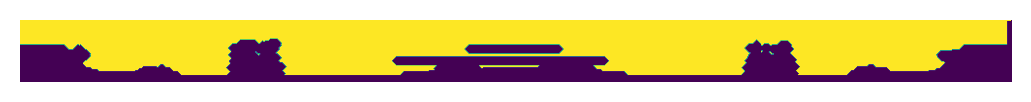

In [95]:
existVals = np.load("existTotalLiDARGenSettings.npy")
import scipy

import matplotlib.pyplot as plt
existVals = existVals > np.max(existVals)//3
existVals[2:] = scipy.ndimage.binary_erosion(existVals[2:], border_value = 1, iterations=4)
# existVals[:15] = scipy.ndimage.binary_closing(existVals[:15], border_value = 1, iterations=3)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)


%matplotlib inline

plt.rcParams['figure.dpi'] = 200
print("original")

plt.imshow(existVals)
plt.axis('off')
plt.show()

TypeError: Invalid shape () for image data

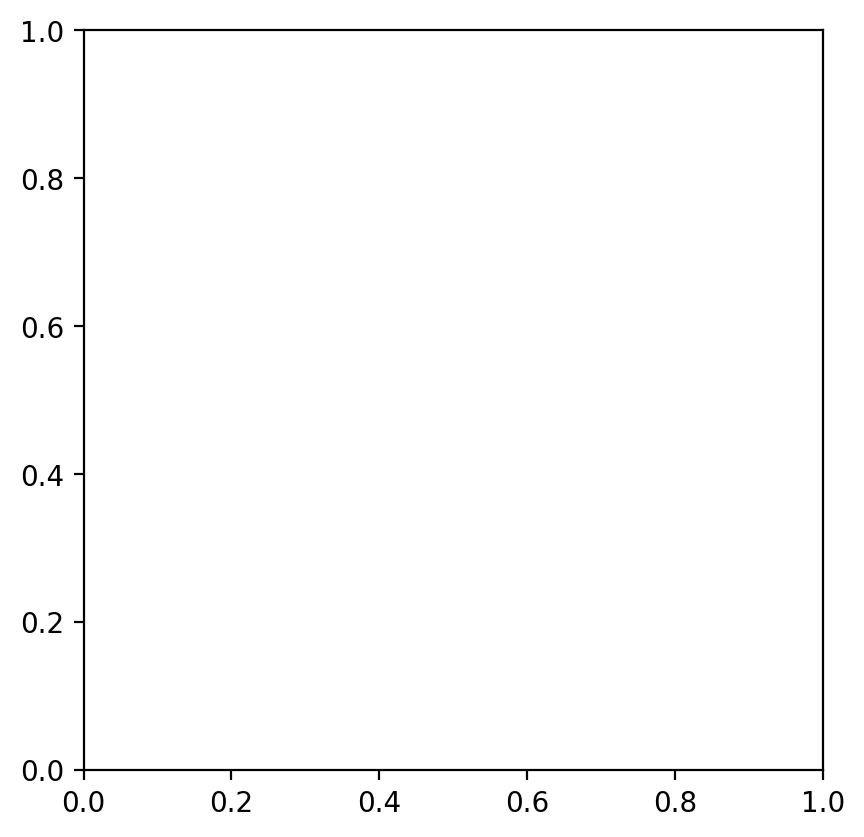

['DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/0.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/1.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/10.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/11.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/12.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/13.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/14.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/15.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/16.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/17.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/18.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/19.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/2.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/20.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/21.npy'
 'DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/22.npy'
 'DGXDataLi

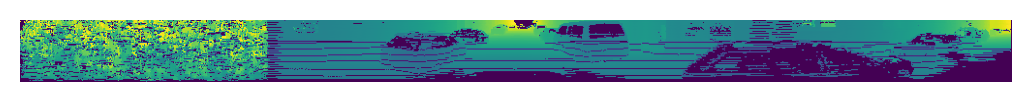

original


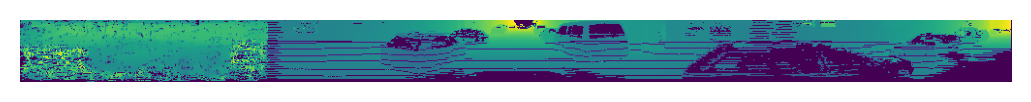

original


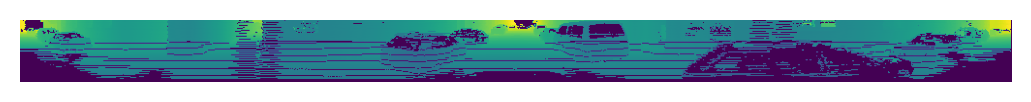

In [125]:
import numpy as np
import torch
from glob import glob
numberToLoad = str(21)
# actualList = np.argsort(glob("DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/*.npy"))
print(np.sort(glob("DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/*.npy")))
print(np.argsort(glob("DGXDataLiDARGenSettings/Line/LiDARGen/Organised/k_5/*.npy")))
print(actualList[0])
# data = torch.load("DGXDataLiDARGenSettings/Inpainting/LiDARGen/Organised/k_0/result_rangenet_segmentations/2.pth")
data = np.load("DGXDataLiDARGenSettings/Inpainting/LiDARGen/Organised/k_0/" + numberToLoad + ".npy")[0,0]
print(data.shape)
# test = segmentedVals[0]
import scipy

import matplotlib.pyplot as plt
# existVals = existVals > 7
# existVals[2:] = scipy.ndimage.binary_erosion(existVals[2:], border_value = 1, iterations=4)
# existVals[:15] = scipy.ndimage.binary_closing(existVals[:15], border_value = 1, iterations=3)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)


%matplotlib inline

plt.rcParams['figure.dpi'] = 200
print("original")


# plt.imshow(data.cpu())
plt.imshow(data)
plt.axis('off')
plt.show()

# data = torch.load("DGXDataLiDARGenSettings/Inpainting/Simultaneous/Organised/k_0/result_rangenet_segmentations/2.pth")
data = np.load("DGXDataLiDARGenSettings/Inpainting/Simultaneous/Organised/k_0/" + numberToLoad + ".npy")[0,0]
plt.rcParams['figure.dpi'] = 200
print("original")

# plt.imshow(data.cpu())
plt.imshow(data)
plt.axis('off')
plt.show()

# data = torch.load("DGXDataLiDARGenSettings/Inpainting/GroundTruth/Organised/k_0/target_rangenet_segmentations/2.pth")
data = np.load("DGXDataLiDARGenSettings/Inpainting/GroundTruth/Organised/k_0/" + numberToLoad + ".npy")[0,0]
plt.rcParams['figure.dpi'] = 200
print("original")

# plt.imshow(data.cpu())
plt.imshow(data)
plt.axis('off')
plt.show()

torch.Size([64, 1024])
original


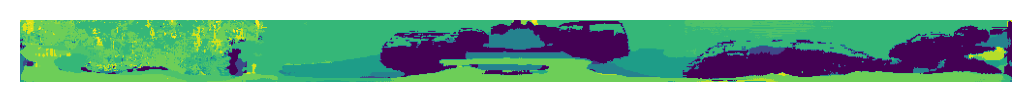

original


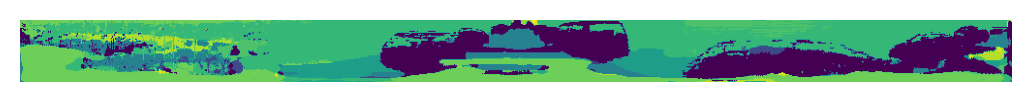

original


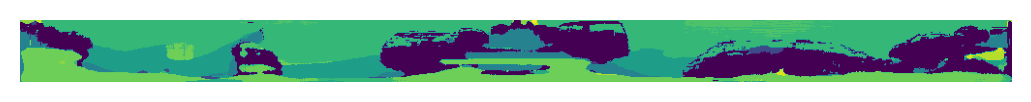

In [126]:
import numpy as np
import torch
numberToLoad = str(21)

data = torch.load("DGXDataLiDARGenSettings/Inpainting/LiDARGen/Organised/k_0/result_rangenet_segmentations/" + numberToLoad + ".pth")
# data = np.load("DGXDataLiDARGenSettings/Inpainting/LiDARGen/Organised/k_0/" + numberToLoad + ".npy")[0,0]
print(data.shape)
# test = segmentedVals[0]
import scipy

import matplotlib.pyplot as plt
# existVals = existVals > 7
# existVals[2:] = scipy.ndimage.binary_erosion(existVals[2:], border_value = 1, iterations=4)
# existVals[:15] = scipy.ndimage.binary_closing(existVals[:15], border_value = 1, iterations=3)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)
# existVals = scipy.ndimage.binary_dilation(existVals, border_value = 0, iterations=1)


%matplotlib inline

plt.rcParams['figure.dpi'] = 200
print("original")


plt.imshow(data.cpu())
# plt.imshow(data)
plt.axis('off')
plt.show()

data = torch.load("DGXDataLiDARGenSettings/Inpainting/Simultaneous/Organised/k_0/result_rangenet_segmentations/" + numberToLoad + ".pth")
# data = np.load("DGXDataLiDARGenSettings/Inpainting/Simultaneous/Organised/k_0/" + numberToLoad + ".npy")[0,0]
plt.rcParams['figure.dpi'] = 200
print("original")

plt.imshow(data.cpu())
# plt.imshow(data)
plt.axis('off')
plt.show()

data = torch.load("DGXDataLiDARGenSettings/Inpainting/GroundTruth/Organised/k_0/target_rangenet_segmentations/" + numberToLoad + ".pth")
# data = np.load("DGXDataLiDARGenSettings/Inpainting/GroundTruth/Organised/k_0/" + numberToLoad + ".npy")[0,0]
plt.rcParams['figure.dpi'] = 200
print("original")

plt.imshow(data.cpu())
# plt.imshow(data)
plt.axis('off')
plt.show()